## COVID19 Analytics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv("COVID19.csv")
df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40954,NaN,NaN,International,2020-08-28,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40955,NaN,NaN,International,2020-08-29,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40956,NaN,NaN,International,2020-08-30,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40957,NaN,NaN,International,2020-08-31,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy'],
      dtype='object')

# Initial Question & Hyptothesis


•How does access to handwashing facilities impact the spread and severity of the pandemic? Is having handwashing facilities especially important when population density is high?

    > Hypothesis: Countries with high access sanitary facilities are likely to contain the spread of the pandemic better. 

    > Is there correlation between handwashing_facilities (share of the population with basic handwashing facilities on premises) and dependent variables like “total_cases_per_million”

    > Can you use “handwashing_facilities” and “population_density” to predict “total_cases_per_million”

• Does increase in testing help manage the impact of the pandemic? 

    > Hypothesis: Increasing in testing will mean less people who are asymptomatic will spread covid. 

    > Design a new column that measures how well a country is managing the pandemic. 


## Function showing correlation between two variables (at most recent time point)

In [4]:
def correlate(a,b, outlier_list=[], show_detail = False):
    print("relationship between:", a,"&", b)
    df1 = df
    original_list = df1.iso_code.unique()
    df1 = df1[df1[a].notna()]
    df1 = df1[df1[b].notna()]
    df1 = df1[df1['date'] == '2020-09-01']
    df1 = df1[df1['iso_code'] != 'OWID_WRL']
    
    if outlier_list:
        for code in outlier_list:
            df1 = df1[df1['iso_code'] != code]
    
    filtered_list = df1.iso_code.unique()
    
    deleted_countries = list(set(original_list)-set(filtered_list))
    
    df1 = df1.sort_values(by=[a], ascending=False)
    if show_detail:
        print(df1)
    print(len(deleted_countries), "countries not accounted for")

    sns.relplot(x=a, y=b, data=df1)
    X = df1[a]
    Y = df1[b]
    
    #covariance of the two variables divided by the product of the standard deviation
    corr, _ = pearsonr(X, Y)
    print('Pearsons correlation: %.3f' % corr)
    
#     X_a = [[i, x] for i, x in enumerate(X)]
#     Y_b = [[i, x] for i, x in enumerate(Y)]
#     lr = LinearRegression()
#     lr.fit(X_a, Y_b)
#     y_pred = lr.predict(X_a)
#     plt.scatter(X_a,Y_b)
#     plt.plot(X_a,y_pred)
#     plt.show()


## Examples

relationship between: gdp_per_capita & life_expectancy
33 countries not accounted for
Pearsons correlation: 0.709


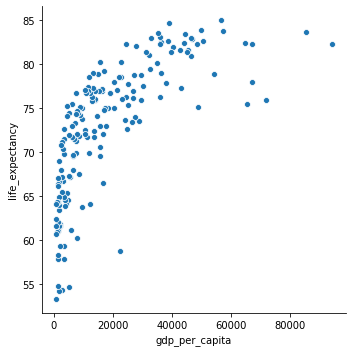

In [7]:
correlate("gdp_per_capita","life_expectancy",['QAT'])

relationship between: gdp_per_capita & extreme_poverty
95 countries not accounted for
Pearsons correlation: -0.559


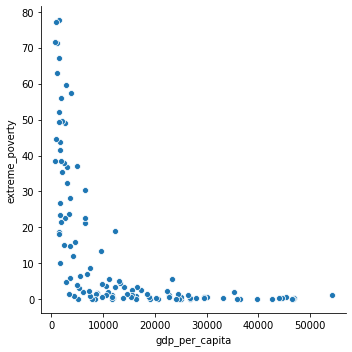

In [8]:
correlate("gdp_per_capita","extreme_poverty",['LUX', 'IRL','NOR'])

relationship between: gdp_per_capita & total_cases_per_million
32 countries not accounted for
Pearsons correlation: 0.390


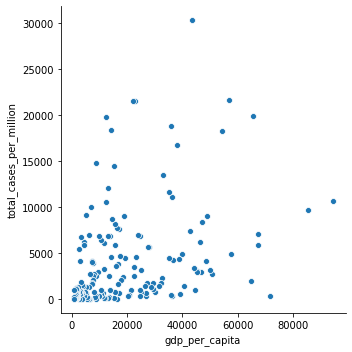

In [9]:
correlate("gdp_per_capita","total_cases_per_million",['QAT'])

## Handwashing_facilities 

relationship between: gdp_per_capita & handwashing_facilities
125 countries not accounted for
Pearsons correlation: 0.700


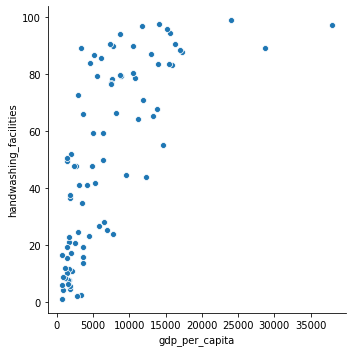

In [10]:
correlate("gdp_per_capita","handwashing_facilities",['GNQ'])

There is a clear positive correlation between gdp and access to handwashing facilities. This makes intuitive sense since developed countries can afford to build more sanitary facilities.

relationship between: handwashing_facilities & total_cases_per_million
122 countries not accounted for
Pearsons correlation: 0.454


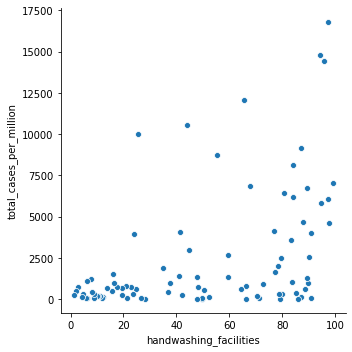

In [11]:
correlate("handwashing_facilities","total_cases_per_million",['GNQ'])

relationship between: handwashing_facilities & population_density
123 countries not accounted for
Pearsons correlation: 0.086


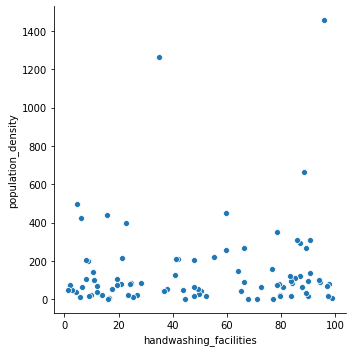

In [12]:
correlate("handwashing_facilities","population_density",['GNQ'])

No correlation between population density and handwashing facilities. 

In [13]:
def most_correlated(a):
    li = []
    for col in df.columns:
        if col == 'iso_code' or col == 'continent' or col == 'location' or col == 'date' or col == a:
            continue
        df1 = df
        df1 = df1[df1[a].notna()]
        df1 = df1[df1[col].notna()]
        df1 = df1[df1['date'] == '2020-09-01']
        df1 = df1[df1['iso_code'] != 'OWID_WRL']

        X = df1[a]
        Y = df1[col]
        if len(X) == 0:
            continue
        corr, _ = pearsonr(X, Y)
        corr = float(str(round(corr, 3)))
        li.append([corr,col])
#         print('Pearsons correlation: %.3f' % corr)
    li = sorted(li, key=lambda x: abs(x[0]))
    return li[::-1]

In [14]:
list_of_scores = most_correlated('handwashing_facilities')
list_of_scores

[[0.828, 'life_expectancy'],
 [0.786, 'median_age'],
 [-0.759, 'extreme_poverty'],
 [0.655, 'gdp_per_capita'],
 [0.641, 'aged_65_older'],
 [0.637, 'aged_70_older'],
 [0.566, 'diabetes_prevalence'],
 [0.45, 'total_cases_per_million'],
 [0.448, 'hospital_beds_per_thousand'],
 [0.438, 'new_cases_smoothed_per_million'],
 [0.362, 'new_cases_per_million'],
 [0.358, 'total_deaths_per_million'],
 [0.331, 'male_smokers'],
 [0.314, 'new_deaths_smoothed_per_million'],
 [0.297, 'new_deaths_per_million'],
 [0.295, 'female_smokers'],
 [0.154, 'total_deaths'],
 [0.121, 'new_deaths_smoothed'],
 [0.117, 'new_deaths'],
 [0.09, 'population_density'],
 [0.088, 'total_cases'],
 [0.062, 'new_cases_smoothed'],
 [0.061, 'new_cases'],
 [-0.043, 'cardiovasc_death_rate'],
 [0.039, 'population']]

In [15]:
list_of_scores = most_correlated('total_deaths_per_million')
list_of_scores

[[0.556, 'total_cases_per_million'],
 [0.517, 'new_cases_per_million'],
 [0.427, 'total_deaths'],
 [0.404, 'new_deaths_smoothed_per_million'],
 [0.358, 'handwashing_facilities'],
 [0.35, 'life_expectancy'],
 [-0.344, 'cardiovasc_death_rate'],
 [0.325, 'aged_70_older'],
 [-0.324, 'extreme_poverty'],
 [0.317, 'aged_65_older'],
 [0.306, 'median_age'],
 [0.306, 'new_cases_smoothed_per_million'],
 [0.302, 'female_smokers'],
 [0.3, 'new_deaths_smoothed'],
 [0.3, 'total_cases'],
 [0.298, 'gdp_per_capita'],
 [0.291, 'new_deaths'],
 [0.206, 'new_cases_smoothed'],
 [0.196, 'new_cases'],
 [0.189, 'new_deaths_per_million'],
 [-0.147, 'male_smokers'],
 [-0.069, 'diabetes_prevalence'],
 [-0.04, 'population_density'],
 [0.038, 'hospital_beds_per_thousand'],
 [0.008, 'population']]

In [16]:
def get_data(a):
    df1 = df
    df1 = df1[df1[a].notna()]
    df1 = df1[df1['date'] == '2020-09-01']
    df1 = df1[df1['iso_code'] != 'OWID_WRL']
    df1 = df1.sort_values(by=[a], ascending=False)
    return df1

In [17]:
df_handwash = get_data('handwashing_facilities')
df_handwash

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
19919,KAZ,Asia,Kazakhstan,2020-09-01,131596.0,923.0,590.571,1815.0,34.0,4.857,...,4.625,24055.588,0.1,466.792,7.11,7.0,43.1,98.999,6.700,73.60
32338,SRB,Europe,Serbia,2020-09-01,31406.0,41.0,98.857,713.0,2.0,1.714,...,NaN,14048.881,NaN,439.415,10.08,37.7,40.2,97.719,5.609,76.00
28083,OMN,Asia,Oman,2020-09-01,85722.0,178.0,173.286,685.0,8.0,6.857,...,1.530,37960.709,NaN,266.342,12.61,0.5,15.6,97.400,1.600,77.86
5121,BIH,Europe,Bosnia and Herzegovina,2020-09-01,19964.0,175.0,276.714,609.0,17.0,9.857,...,10.711,11713.895,0.2,329.635,10.08,30.2,47.7,97.164,3.500,77.40
23370,MDV,Asia,Maldives,2020-09-01,7808.0,141.0,128.000,28.0,0.0,0.143,...,2.875,15183.616,NaN,164.905,9.19,2.1,55.0,95.803,NaN,78.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30894,RWA,Africa,Rwanda,2020-09-01,4063.0,43.0,108.143,16.0,0.0,0.286,...,1.642,1854.211,56.0,191.375,4.28,4.7,21.0,4.617,NaN,69.02
10121,COD,Africa,Democratic Republic of Congo,2020-09-01,10096.0,52.0,36.429,257.0,0.0,1.000,...,1.745,808.133,77.1,318.949,6.10,NaN,NaN,4.472,NaN,60.68
6779,CMR,Africa,Cameroon,2020-09-01,19142.0,0.0,54.286,411.0,0.0,0.429,...,1.919,3364.926,23.8,244.661,7.20,NaN,NaN,2.735,1.300,59.29
21387,LSO,Africa,Lesotho,2020-09-01,1085.0,19.0,10.000,31.0,0.0,0.143,...,2.647,2851.153,59.6,405.126,3.94,0.4,53.9,2.117,NaN,54.33


In [18]:
avg = df_handwash['population_density'].mean()
df_handwash['population_density'].fillna(avg, inplace= True) #1 missing value filled. 


y = df_handwash['total_cases_per_million']
x = df_handwash[['handwashing_facilities','population_density']]
x = StandardScaler().fit_transform(x)


lr = LinearRegression()
y = np.array(y)
x = np.array(x)
# x = np.array(x).reshape(-1,1)
lr.fit(x,y)
y_pred = lr.predict(x)
# plt.scatter(x,y)
# plt.plot(x,y_pred)
# plt.show()
print(r2_score(y,y_pred))
# lr.intercept_
print('coefficients:', lr.coef_)



0.20992091464772922
coefficients: [1613.8749255   321.02368708]


In [ ]:
# df_all = get_data('gdp_per_capita')
# df_all.isnull().sum()

# df_all.drop(['new_tests','total_tests','total_tests_per_thousand','new_tests_smoothed'], axis=1, inplace=True)
# df_all.drop(['new_tests_per_thousand','new_tests_smoothed_per_thousand','tests_per_case','positive_rate'], axis=1, inplace=True)
# df_all.drop(['tests_units','stringency_index','handwashing_facilities'], axis=1, inplace=True)
# df_all.drop(['extreme_poverty'], axis=1, inplace=True)

# avg = df_all['population_density'].mean()
# df_all['population_density'].fillna(avg, inplace= True)
# avg = df_all['median_age'].mean()
# df_all['median_age'].fillna(avg, inplace= True)
# avg = df_all['aged_65_older'].mean()
# df_all['aged_65_older'].fillna(avg, inplace= True)
# avg = df_all['aged_70_older'].mean()
# df_all['aged_70_older'].fillna(avg, inplace= True)
# avg = df_all['cardiovasc_death_rate'].mean()
# df_all['cardiovasc_death_rate'].fillna(avg, inplace= True)
# avg = df_all['diabetes_prevalence'].mean()
# df_all['diabetes_prevalence'].fillna(avg, inplace= True)
# avg = df_all['female_smokers'].mean()
# df_all['female_smokers'].fillna(avg, inplace= True)
# avg = df_all['male_smokers'].mean()
# df_all['male_smokers'].fillna(avg, inplace= True)
# avg = df_all['hospital_beds_per_thousand'].mean()
# df_all['hospital_beds_per_thousand'].fillna(avg, inplace= True)
# avg = df_all['life_expectancy'].mean()
# df_all['life_expectancy'].fillna(avg, inplace= True)
# df_all

In [20]:
# y = df_all['new_cases']
# x = df_all[['total_cases_per_million','population','population_density','median_age','aged_65_older','gdp_per_capita','cardiovasc_death_rate','diabetes_prevalence','female_smokers','male_smokers','hospital_beds_per_thousand','life_expectancy']]
# x = StandardScaler().fit_transform(x)

# lr = LinearRegression()
# y = np.array(y)
# x = np.array(x)
# lr.fit(x,y)
# y_pred = lr.predict(x)
# print(r2_score(y,y_pred))

# lr.coef_


In [21]:
df['worst_day_new_cases_per_million'] = df['new_cases_per_million']
for country in df['iso_code'].unique():
    m = df[df['iso_code'] == country]['new_cases_per_million'].max()
    df['worst_day_new_cases_per_million'][df['iso_code']==country] = m
    
df['worst_day_death'] = df['new_deaths']
for country in df['iso_code'].unique():
    m = df[df['iso_code'] == country]['new_deaths'].max()
    df['worst_day_death'][df['iso_code']==country] = m
    
df
    

/Users/david/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/david/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,worst_day_new_cases_per_million,worst_day_death
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,27.307,56.0
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,27.307,56.0
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,27.307,56.0
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,27.307,56.0
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,27.307,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40954,NaN,NaN,International,2020-08-28,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40955,NaN,NaN,International,2020-08-29,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40956,NaN,NaN,International,2020-08-30,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40957,NaN,NaN,International,2020-08-31,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df_all = get_data('gdp_per_capita')
df_all.isnull().sum()

df_all.drop(['new_tests','total_tests','total_tests_per_thousand','new_tests_smoothed'], axis=1, inplace=True)
df_all.drop(['new_tests_per_thousand','new_tests_smoothed_per_thousand','tests_per_case','positive_rate'], axis=1, inplace=True)
df_all.drop(['tests_units','stringency_index','handwashing_facilities'], axis=1, inplace=True)
df_all.drop(['extreme_poverty'], axis=1, inplace=True)

avg = df_all['population_density'].mean()
df_all['population_density'].fillna(avg, inplace= True)
avg = df_all['median_age'].mean()
df_all['median_age'].fillna(avg, inplace= True)
avg = df_all['aged_65_older'].mean()
df_all['aged_65_older'].fillna(avg, inplace= True)
avg = df_all['aged_70_older'].mean()
df_all['aged_70_older'].fillna(avg, inplace= True)
avg = df_all['cardiovasc_death_rate'].mean()
df_all['cardiovasc_death_rate'].fillna(avg, inplace= True)
avg = df_all['diabetes_prevalence'].mean()
df_all['diabetes_prevalence'].fillna(avg, inplace= True)
avg = df_all['female_smokers'].mean()
df_all['female_smokers'].fillna(avg, inplace= True)
avg = df_all['male_smokers'].mean()
df_all['male_smokers'].fillna(avg, inplace= True)
avg = df_all['hospital_beds_per_thousand'].mean()
df_all['hospital_beds_per_thousand'].fillna(avg, inplace= True)
avg = df_all['life_expectancy'].mean()
df_all['life_expectancy'].fillna(avg, inplace= True)

In [23]:
y = df_all['worst_day_new_cases_per_million']
x = df_all[['population','population_density','median_age','aged_65_older','aged_70_older','gdp_per_capita','cardiovasc_death_rate','diabetes_prevalence','female_smokers','male_smokers','hospital_beds_per_thousand','life_expectancy']]
x = StandardScaler().fit_transform(x)
# y = StandardScaler().fit_transform(y)


lr = LinearRegression()
y = np.array(y)
x = np.array(x)
lr.fit(x,y)
y_pred = lr.predict(x)
print(r2_score(y,y_pred))

lr.coef_



0.15998774194346732


array([ -17.41447907,    5.89764258,  119.48729439, -282.69185345,
         28.17545305,   36.09068929,  -11.76907376,  -23.63102012,
         78.40414442,    1.60553089,   17.47225951,   77.59309035])

In [24]:
y = df_all['worst_day_death']
x = df_all[['population','population_density','median_age','aged_65_older','aged_70_older','gdp_per_capita','cardiovasc_death_rate','diabetes_prevalence','female_smokers','male_smokers','hospital_beds_per_thousand','life_expectancy']]
x = StandardScaler().fit_transform(x)
# y = StandardScaler().fit_transform(y)


lr = LinearRegression()
y = np.array(y)
x = np.array(x)
lr.fit(x,y)
y_pred = lr.predict(x)
print(r2_score(y,y_pred))

lr.coef_

0.2429281334529938


array([240.70691919, -45.50979283, -15.54321848, -28.34397456,
        32.36697944,  17.23459074, -75.27081764, -12.64628734,
        70.58814467,  -7.23831648, -44.95500163,  50.20026863])

In [ ]:
# countries, result = rank_independent_variable('handwashing_facilities')
# for i in range(len(result)):
#     result[i] = float(str(round(result[i], 3)))
# list(zip(countries,result)) 

In [ ]:
# df['death_rate'] = (df['total_deaths'] / df['total_cases'])


# lis = []
# countries, _ = rank_independent_variable('handwashing_facilities')
# countries = countries[:10]

# for i,country in enumerate(countries):
#     lis.append(list(df[df['location'] == country]['death_rate']))
#     print(len(lis[i]))

# print(countries)
# print(len(lis))
# lis = list(map(list, zip(*lis)))
# df_plot = pd.DataFrame(lis, columns = countries)

# df_plot['date'] = df['date']


In [ ]:
# df_plot.date = pd.to_datetime(df_plot.date)
# df_plot.set_index('date',inplace = True)
# df_plot.plot()


In [26]:
from dateutil.parser import parse 
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
df = pd.read_csv("COVID19.csv", parse_dates=['date'], index_col='date')
df_usa = df[df['iso_code'] == 'USA'][68:-4]

df_usa['new_death_new_cases_ratio'] = (df_usa['new_deaths'] / df_usa['new_cases'])
    
def graph(a):
    def plot_df(df, x, y, title="", xlabel='Date', ylabel=a.name, dpi=100):
        plt.figure(figsize=(16,5), dpi=dpi)
        plt.plot(x, y, color='tab:red')
        plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
        plt.show()
    
    plot_df(df_usa, x=df_usa.index, y=a, title='USA '+a.name +' 03/20 - 08/20')  

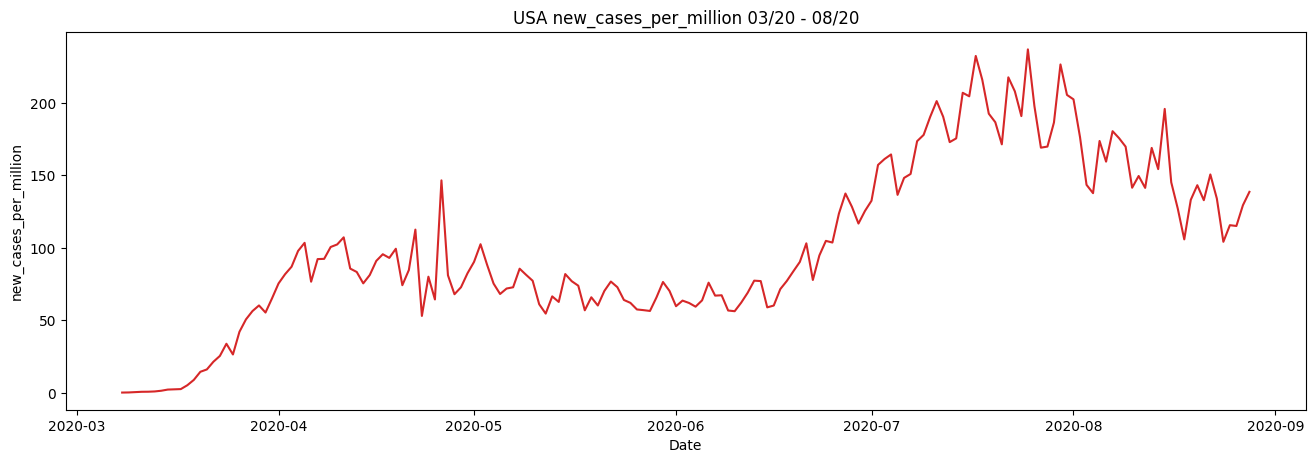

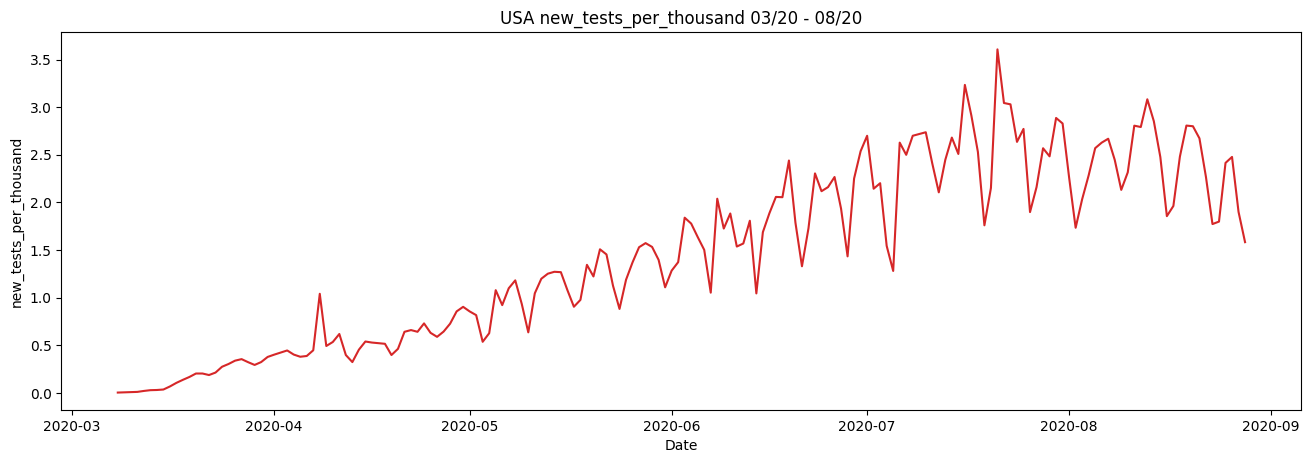

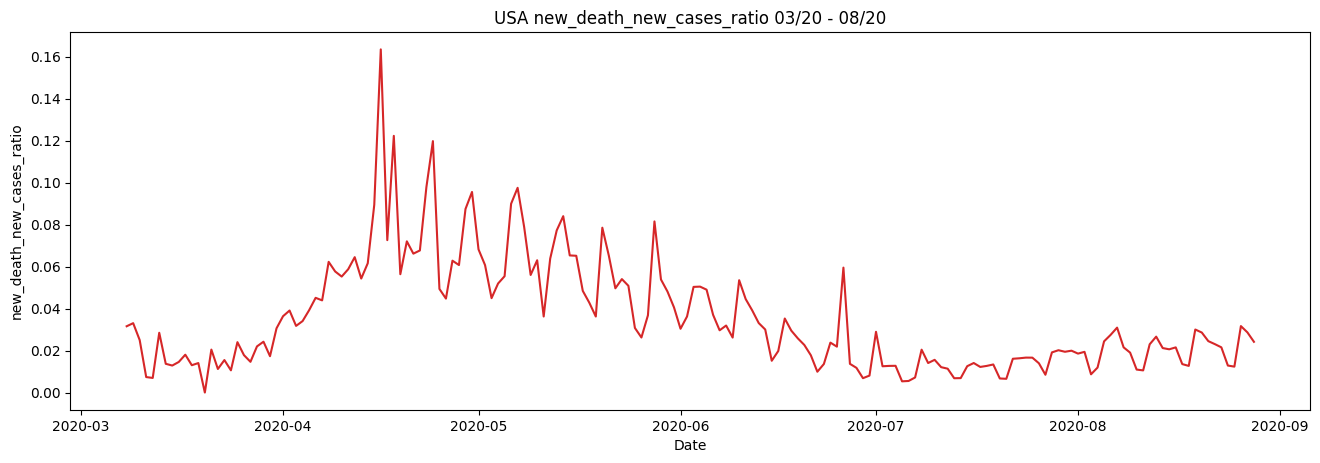

In [28]:
graph(df_usa.new_cases_per_million)
graph(df_usa.new_tests_per_thousand)
graph(df_usa.new_death_new_cases_ratio)

In [ ]:
# df_usa.isnull().sum()

0.1491828440973738


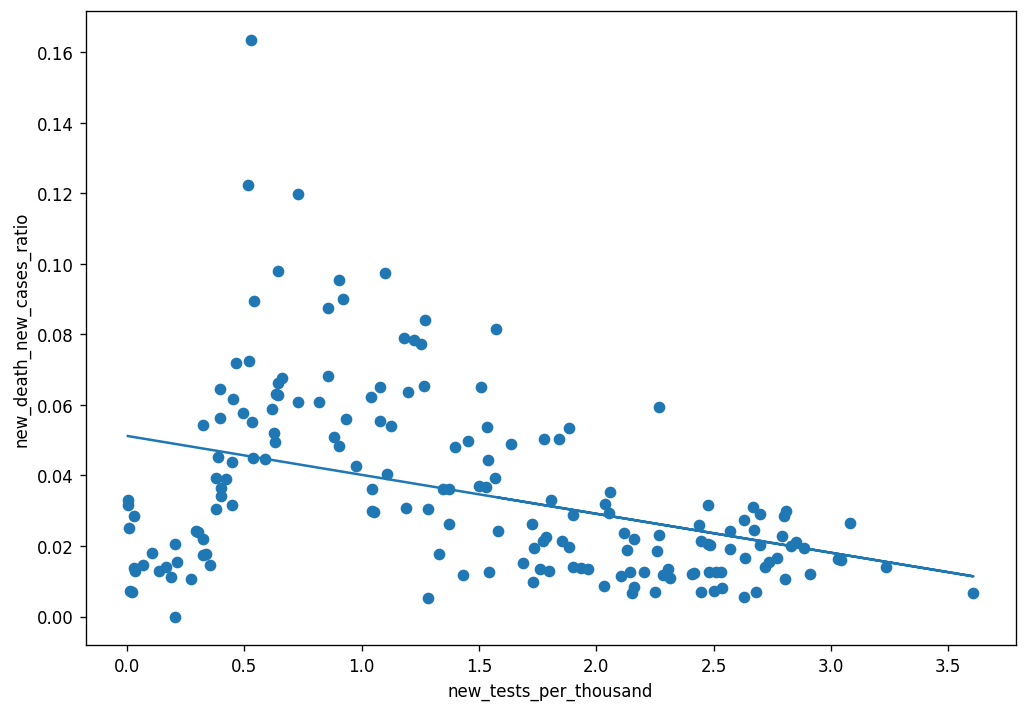

In [29]:
y = df_usa['new_death_new_cases_ratio']
x = df_usa['new_tests_per_thousand']

lr = LinearRegression()
y = np.array(y)
x = np.array(x).reshape(-1,1)
lr.fit(x,y)
y_pred = lr.predict(x)
plt.scatter(x,y,)
plt.plot(x,y_pred)
plt.xlabel('new_tests_per_thousand')
plt.ylabel('new_death_new_cases_ratio')
print(r2_score(y,y_pred))